In [14]:
from keras import models
from keras import layers
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Generator Model

In [2]:
model1 = models.Sequential()
model1.add(layers.Dense(input_dim=100,output_dim=1024,activation="tanh"))
model1.add(layers.Dense(128*7*7,activation="tanh"))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation("tanh"))
model1.add(layers.Reshape((7,7,128),input_shape=(128*7*7,)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.Conv2D(64,(5,5),padding='same',activation='tanh'))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.Conv2D(1,(5,5),padding='same',activation='tanh'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, activation="tanh", units=1024)`
  


In [3]:
help("keras.layers.Conv2D")

Help on class Conv2D in keras.layers:

keras.layers.Conv2D = class Conv2D(_Conv)
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
 |  in `data_format="channels_last"`.
 |  
 |  # Arguments
 |      filters: Integer, the dimensionality of the output space
 |          (i.e. the number of output filters in the convolution).
 |      kernel_size: An integer or tuple/list of 2 integers, specifying the
 |          height and width of the 2D convolution window.
 |       

# Dsicriminator

In [4]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64,(5,5),padding='same',input_shape=(28,28,1),activation='tanh'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128,(5,5),activation='tanh'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(1024,activation='tanh'))
model2.add(layers.Dense(1,activation='sigmoid'))

# Final Model

In [5]:
model = models.Sequential()
model.add(model1)
model2.trainable = False
model.add(model2)

# load data

In [6]:
(trainimg,trainlb),(testimg,testlb) = mnist.load_data()
trainimg = trainimg/255
testimg = testimg/255
trainimg = trainimg.reshape(60000,28,28,1)
testimg = testimg.reshape(10000,28,28,1)

# Combining Images

In [7]:
def combine_images(g_images):
    num = g_images.shape[0] # getting the count of images
    width = int(numpy.sqrt(num))
    height = int(numpy.ceil(float(num)/width))
    imgshape = g_images[0].shape
    image = numpy.zeros((height*imgshape[0],width*imgshape[1]),dtype = g_images.dtype)
    for ind,img in enumerate(g_images):
        i = int(ind/width)
        j = ind % width
        image[i*imgshape[0]:(i+1)*imgshape[0],i*imgshape[1]:(j+1)*imgshape[1]] = img[:,:,0]
        return image
    
    

# Compilation

In [8]:
model1_optim = SGD(lr = 0.0005,momentum=0.9,nesterov=True)
model2_optim = SGD(lr = 0.0005,momentum=0.9,nesterov=True)
model1.compile(loss='binary_crossentropy',optimizer="SGD")
model.compile(loss='binary_crossentropy',optimizer=model1_optim)
model2.trainable = True
model2.compile(loss='binary_crossentropy',optimizer=model2_optim)
# training for 100 epochs
for i in range(100):
    print("Epoch is ",i)
    batch_size = 128
    for j in range(int(trainimg.shape[0]/batch_size)):
        noise = numpy.random.uniform(-1,1,size=(batch_size,100))
        img_batch = trainimg[j*batch_size:(j+1)*batch_size]
        g_images = model1.predict(noise,verbose=0)
        if j % 20 ==0:
            img = combine_images(g_images)
            img = img*127.5 + 127.5
            Image.fromarray(img.astype(numpy.uint8)[:28,:28]).save("generated_pictures\\"+str(i)+"_"+str(j)+".png")
            xtrain = numpy.concatenate((img_batch,g_images))
            ytrain = [1]*batch_size +[0] * batch_size
            model2_loss = model2.train_on_batch(xtrain,ytrain)
            print("batch %d discriminator loss : %f"%(j,model2_loss))
            noise = numpy.random.uniform(-1,1,(batch_size,100))
            model2.trainable = False
            model1_loss = model.train_on_batch(noise,[1]*batch_size)
            model2.trainable = True
            print("batch %d generator loss : %f"%(j,model1_loss))

Epoch is  0
batch 0 discriminator loss : 0.708119
batch 0 generator loss : 0.831357
batch 20 discriminator loss : 0.663753
batch 20 generator loss : 0.830319
batch 40 discriminator loss : 0.662342
batch 40 generator loss : 0.829116
batch 60 discriminator loss : 0.658750
batch 60 generator loss : 0.829065
batch 80 discriminator loss : 0.661105
batch 80 generator loss : 0.830729
batch 100 discriminator loss : 0.655301
batch 100 generator loss : 0.831700
batch 120 discriminator loss : 0.645725
batch 120 generator loss : 0.838457
batch 140 discriminator loss : 0.640533
batch 140 generator loss : 0.842123
batch 160 discriminator loss : 0.627806
batch 160 generator loss : 0.849596
batch 180 discriminator loss : 0.629772
batch 180 generator loss : 0.851282
batch 200 discriminator loss : 0.622365
batch 200 generator loss : 0.856646
batch 220 discriminator loss : 0.618910
batch 220 generator loss : 0.869758
batch 240 discriminator loss : 0.611235
batch 240 generator loss : 0.872737
batch 260 di

batch 240 discriminator loss : 0.278228
batch 240 generator loss : 1.970898
batch 260 discriminator loss : 0.289874
batch 260 generator loss : 1.960992
batch 280 discriminator loss : 0.304506
batch 280 generator loss : 1.989525
batch 300 discriminator loss : 0.264588
batch 300 generator loss : 2.027605
batch 320 discriminator loss : 0.269641
batch 320 generator loss : 2.012894
batch 340 discriminator loss : 0.265015
batch 340 generator loss : 2.023075
batch 360 discriminator loss : 0.255763
batch 360 generator loss : 2.050796
batch 380 discriminator loss : 0.255544
batch 380 generator loss : 2.062482
batch 400 discriminator loss : 0.217410
batch 400 generator loss : 2.052361
batch 420 discriminator loss : 0.251451
batch 420 generator loss : 2.087202
batch 440 discriminator loss : 0.225909
batch 440 generator loss : 2.123839
batch 460 discriminator loss : 0.235289
batch 460 generator loss : 2.114729
Epoch is  5
batch 0 discriminator loss : 0.226064
batch 0 generator loss : 2.157352
batc

batch 0 discriminator loss : 0.401138
batch 0 generator loss : 1.358085
batch 20 discriminator loss : 0.383380
batch 20 generator loss : 1.401376
batch 40 discriminator loss : 0.361635
batch 40 generator loss : 1.461689
batch 60 discriminator loss : 0.378116
batch 60 generator loss : 1.350652
batch 80 discriminator loss : 0.343570
batch 80 generator loss : 1.411686
batch 100 discriminator loss : 0.414115
batch 100 generator loss : 1.383673
batch 120 discriminator loss : 0.399898
batch 120 generator loss : 1.460570
batch 140 discriminator loss : 0.397634
batch 140 generator loss : 1.454684
batch 160 discriminator loss : 0.370515
batch 160 generator loss : 1.406237
batch 180 discriminator loss : 0.367816
batch 180 generator loss : 1.470665
batch 200 discriminator loss : 0.389086
batch 200 generator loss : 1.438147
batch 220 discriminator loss : 0.383768
batch 220 generator loss : 1.462210
batch 240 discriminator loss : 0.412176
batch 240 generator loss : 1.445446
batch 260 discriminator 

batch 240 discriminator loss : 0.280076
batch 240 generator loss : 1.755094
batch 260 discriminator loss : 0.259291
batch 260 generator loss : 1.815460
batch 280 discriminator loss : 0.268083
batch 280 generator loss : 1.674896
batch 300 discriminator loss : 0.264199
batch 300 generator loss : 1.695714
batch 320 discriminator loss : 0.268189
batch 320 generator loss : 1.685973
batch 340 discriminator loss : 0.275206
batch 340 generator loss : 1.687716
batch 360 discriminator loss : 0.269193
batch 360 generator loss : 1.688791
batch 380 discriminator loss : 0.265521
batch 380 generator loss : 1.664970
batch 400 discriminator loss : 0.309650
batch 400 generator loss : 1.738651
batch 420 discriminator loss : 0.265296
batch 420 generator loss : 1.692666
batch 440 discriminator loss : 0.246802
batch 440 generator loss : 1.696067
batch 460 discriminator loss : 0.277872
batch 460 generator loss : 1.766367
Epoch is  14
batch 0 discriminator loss : 0.268570
batch 0 generator loss : 1.716361
bat

batch 0 discriminator loss : 0.336334
batch 0 generator loss : 1.193398
batch 20 discriminator loss : 0.341498
batch 20 generator loss : 1.117908
batch 40 discriminator loss : 0.367230
batch 40 generator loss : 1.085134
batch 60 discriminator loss : 0.379236
batch 60 generator loss : 1.040801
batch 80 discriminator loss : 0.432746
batch 80 generator loss : 0.964757
batch 100 discriminator loss : 0.399465
batch 100 generator loss : 0.962149
batch 120 discriminator loss : 0.410334
batch 120 generator loss : 0.881125
batch 140 discriminator loss : 0.429972
batch 140 generator loss : 0.870082
batch 160 discriminator loss : 0.425004
batch 160 generator loss : 0.921002
batch 180 discriminator loss : 0.425668
batch 180 generator loss : 0.933351
batch 200 discriminator loss : 0.396514
batch 200 generator loss : 0.955103
batch 220 discriminator loss : 0.397208
batch 220 generator loss : 0.987442
batch 240 discriminator loss : 0.374723
batch 240 generator loss : 1.026493
batch 260 discriminator 

batch 240 discriminator loss : 0.557610
batch 240 generator loss : 0.964020
batch 260 discriminator loss : 0.579167
batch 260 generator loss : 1.020334
batch 280 discriminator loss : 0.567272
batch 280 generator loss : 1.126863
batch 300 discriminator loss : 0.480570
batch 300 generator loss : 1.244613
batch 320 discriminator loss : 0.439448
batch 320 generator loss : 1.397424
batch 340 discriminator loss : 0.407867
batch 340 generator loss : 1.599599
batch 360 discriminator loss : 0.347931
batch 360 generator loss : 1.843023
batch 380 discriminator loss : 0.280986
batch 380 generator loss : 2.038464
batch 400 discriminator loss : 0.260126
batch 400 generator loss : 2.196146
batch 420 discriminator loss : 0.241507
batch 420 generator loss : 2.236829
batch 440 discriminator loss : 0.225593
batch 440 generator loss : 2.271297
batch 460 discriminator loss : 0.209366
batch 460 generator loss : 2.239880
Epoch is  23
batch 0 discriminator loss : 0.226595
batch 0 generator loss : 2.171440
bat

Epoch is  27
batch 0 discriminator loss : 0.337398
batch 0 generator loss : 1.421911
batch 20 discriminator loss : 0.313743
batch 20 generator loss : 1.435240
batch 40 discriminator loss : 0.324426
batch 40 generator loss : 1.530802
batch 60 discriminator loss : 0.314595
batch 60 generator loss : 1.579533
batch 80 discriminator loss : 0.323482
batch 80 generator loss : 1.572649
batch 100 discriminator loss : 0.335474
batch 100 generator loss : 1.564884
batch 120 discriminator loss : 0.336030
batch 120 generator loss : 1.533815
batch 140 discriminator loss : 0.331045
batch 140 generator loss : 1.505893
batch 160 discriminator loss : 0.335634
batch 160 generator loss : 1.562740
batch 180 discriminator loss : 0.381840
batch 180 generator loss : 1.463901
batch 200 discriminator loss : 0.374862
batch 200 generator loss : 1.452450
batch 220 discriminator loss : 0.383918
batch 220 generator loss : 1.506673
batch 240 discriminator loss : 0.406866
batch 240 generator loss : 1.469312
batch 260 d

batch 240 discriminator loss : 0.333957
batch 240 generator loss : 1.402524
batch 260 discriminator loss : 0.386963
batch 260 generator loss : 1.367834
batch 280 discriminator loss : 0.391756
batch 280 generator loss : 1.370879
batch 300 discriminator loss : 0.346550
batch 300 generator loss : 1.376672
batch 320 discriminator loss : 0.351279
batch 320 generator loss : 1.412453
batch 340 discriminator loss : 0.362046
batch 340 generator loss : 1.400995
batch 360 discriminator loss : 0.362189
batch 360 generator loss : 1.364742
batch 380 discriminator loss : 0.335296
batch 380 generator loss : 1.410186
batch 400 discriminator loss : 0.355371
batch 400 generator loss : 1.428551
batch 420 discriminator loss : 0.344210
batch 420 generator loss : 1.454628
batch 440 discriminator loss : 0.318699
batch 440 generator loss : 1.438949
batch 460 discriminator loss : 0.333483
batch 460 generator loss : 1.479548
Epoch is  32
batch 0 discriminator loss : 0.336643
batch 0 generator loss : 1.470765
bat

batch 0 discriminator loss : 0.305800
batch 0 generator loss : 1.600646
batch 20 discriminator loss : 0.258274
batch 20 generator loss : 1.610542
batch 40 discriminator loss : 0.284756
batch 40 generator loss : 1.663822
batch 60 discriminator loss : 0.280334
batch 60 generator loss : 1.632355
batch 80 discriminator loss : 0.316394
batch 80 generator loss : 1.567931
batch 100 discriminator loss : 0.300133
batch 100 generator loss : 1.516977
batch 120 discriminator loss : 0.305217
batch 120 generator loss : 1.534996
batch 140 discriminator loss : 0.273314
batch 140 generator loss : 1.580819
batch 160 discriminator loss : 0.266192
batch 160 generator loss : 1.587597
batch 180 discriminator loss : 0.316732
batch 180 generator loss : 1.596566
batch 200 discriminator loss : 0.295328
batch 200 generator loss : 1.588454
batch 220 discriminator loss : 0.298288
batch 220 generator loss : 1.581250
batch 240 discriminator loss : 0.287388
batch 240 generator loss : 1.584509
batch 260 discriminator 

batch 240 discriminator loss : 0.248030
batch 240 generator loss : 1.689969
batch 260 discriminator loss : 0.266939
batch 260 generator loss : 1.718576
batch 280 discriminator loss : 0.296597
batch 280 generator loss : 1.709516
batch 300 discriminator loss : 0.250112
batch 300 generator loss : 1.697211
batch 320 discriminator loss : 0.257713
batch 320 generator loss : 1.735441
batch 340 discriminator loss : 0.261752
batch 340 generator loss : 1.710526
batch 360 discriminator loss : 0.259921
batch 360 generator loss : 1.709486
batch 380 discriminator loss : 0.245028
batch 380 generator loss : 1.731316
batch 400 discriminator loss : 0.241790
batch 400 generator loss : 1.785380
batch 420 discriminator loss : 0.251466
batch 420 generator loss : 1.768221
batch 440 discriminator loss : 0.231263
batch 440 generator loss : 1.787201
batch 460 discriminator loss : 0.215564
batch 460 generator loss : 1.857077
Epoch is  41
batch 0 discriminator loss : 0.248864
batch 0 generator loss : 1.873941
bat

Epoch is  45
batch 0 discriminator loss : 0.255312
batch 0 generator loss : 1.894231
batch 20 discriminator loss : 0.211033
batch 20 generator loss : 1.903599
batch 40 discriminator loss : 0.226558
batch 40 generator loss : 1.931247
batch 60 discriminator loss : 0.238327
batch 60 generator loss : 1.855569
batch 80 discriminator loss : 0.244932
batch 80 generator loss : 1.801280
batch 100 discriminator loss : 0.247268
batch 100 generator loss : 1.788871
batch 120 discriminator loss : 0.241108
batch 120 generator loss : 1.767879
batch 140 discriminator loss : 0.204946
batch 140 generator loss : 1.819834
batch 160 discriminator loss : 0.215942
batch 160 generator loss : 1.748001
batch 180 discriminator loss : 0.242725
batch 180 generator loss : 1.834110
batch 200 discriminator loss : 0.224856
batch 200 generator loss : 1.849664
batch 220 discriminator loss : 0.227437
batch 220 generator loss : 1.851732
batch 240 discriminator loss : 0.232253
batch 240 generator loss : 1.809636
batch 260 d

batch 240 discriminator loss : 0.208920
batch 240 generator loss : 1.939783
batch 260 discriminator loss : 0.247090
batch 260 generator loss : 1.863887
batch 280 discriminator loss : 0.247853
batch 280 generator loss : 1.816426
batch 300 discriminator loss : 0.206343
batch 300 generator loss : 1.877839
batch 320 discriminator loss : 0.204732
batch 320 generator loss : 1.933595
batch 340 discriminator loss : 0.205467
batch 340 generator loss : 1.895320
batch 360 discriminator loss : 0.232927
batch 360 generator loss : 1.924067
batch 380 discriminator loss : 0.201782
batch 380 generator loss : 1.911015
batch 400 discriminator loss : 0.215826
batch 400 generator loss : 1.943421
batch 420 discriminator loss : 0.203613
batch 420 generator loss : 1.845801
batch 440 discriminator loss : 0.192114
batch 440 generator loss : 1.881540
batch 460 discriminator loss : 0.190085
batch 460 generator loss : 1.992535
Epoch is  50
batch 0 discriminator loss : 0.217031
batch 0 generator loss : 1.945032
bat

Epoch is  54
batch 0 discriminator loss : 0.200239
batch 0 generator loss : 2.007132
batch 20 discriminator loss : 0.153496
batch 20 generator loss : 2.065089
batch 40 discriminator loss : 0.181122
batch 40 generator loss : 2.017952
batch 60 discriminator loss : 0.175105
batch 60 generator loss : 2.044448
batch 80 discriminator loss : 0.190509
batch 80 generator loss : 1.969103
batch 100 discriminator loss : 0.191128
batch 100 generator loss : 1.926249
batch 120 discriminator loss : 0.187195
batch 120 generator loss : 1.929893
batch 140 discriminator loss : 0.161390
batch 140 generator loss : 2.016594
batch 160 discriminator loss : 0.169894
batch 160 generator loss : 2.057038
batch 180 discriminator loss : 0.195744
batch 180 generator loss : 1.972528
batch 200 discriminator loss : 0.190693
batch 200 generator loss : 1.983076
batch 220 discriminator loss : 0.183343
batch 220 generator loss : 1.944166
batch 240 discriminator loss : 0.177282
batch 240 generator loss : 1.992004
batch 260 d

batch 240 discriminator loss : 0.168534
batch 240 generator loss : 2.053657
batch 260 discriminator loss : 0.193307
batch 260 generator loss : 2.035396
batch 280 discriminator loss : 0.203571
batch 280 generator loss : 2.046361
batch 300 discriminator loss : 0.167759
batch 300 generator loss : 2.152356
batch 320 discriminator loss : 0.169091
batch 320 generator loss : 2.127545
batch 340 discriminator loss : 0.171301
batch 340 generator loss : 2.265553
batch 360 discriminator loss : 0.177062
batch 360 generator loss : 2.150615
batch 380 discriminator loss : 0.159721
batch 380 generator loss : 2.129183
batch 400 discriminator loss : 0.171304
batch 400 generator loss : 2.126028
batch 420 discriminator loss : 0.175829
batch 420 generator loss : 2.017707
batch 440 discriminator loss : 0.153975
batch 440 generator loss : 2.074033
batch 460 discriminator loss : 0.143880
batch 460 generator loss : 2.157515
Epoch is  59
batch 0 discriminator loss : 0.188792
batch 0 generator loss : 2.068894
bat

batch 0 discriminator loss : 0.146796
batch 0 generator loss : 2.464020
batch 20 discriminator loss : 0.111814
batch 20 generator loss : 2.416986
batch 40 discriminator loss : 0.132482
batch 40 generator loss : 2.363023
batch 60 discriminator loss : 0.133139
batch 60 generator loss : 2.284200
batch 80 discriminator loss : 0.137720
batch 80 generator loss : 2.180724
batch 100 discriminator loss : 0.140653
batch 100 generator loss : 2.239764
batch 120 discriminator loss : 0.140481
batch 120 generator loss : 2.241356
batch 140 discriminator loss : 0.118778
batch 140 generator loss : 2.354260
batch 160 discriminator loss : 0.120255
batch 160 generator loss : 2.431338
batch 180 discriminator loss : 0.139993
batch 180 generator loss : 2.410886
batch 200 discriminator loss : 0.139207
batch 200 generator loss : 2.317574
batch 220 discriminator loss : 0.133636
batch 220 generator loss : 2.340950
batch 240 discriminator loss : 0.129377
batch 240 generator loss : 2.342660
batch 260 discriminator 

batch 240 discriminator loss : 0.110025
batch 240 generator loss : 2.532305
batch 260 discriminator loss : 0.136149
batch 260 generator loss : 2.414994
batch 280 discriminator loss : 0.134671
batch 280 generator loss : 2.432484
batch 300 discriminator loss : 0.101391
batch 300 generator loss : 2.519873
batch 320 discriminator loss : 0.110497
batch 320 generator loss : 2.479451
batch 340 discriminator loss : 0.108149
batch 340 generator loss : 2.617412
batch 360 discriminator loss : 0.114952
batch 360 generator loss : 2.514982
batch 380 discriminator loss : 0.100219
batch 380 generator loss : 2.534896
batch 400 discriminator loss : 0.112546
batch 400 generator loss : 2.503297
batch 420 discriminator loss : 0.112402
batch 420 generator loss : 2.508227
batch 440 discriminator loss : 0.098655
batch 440 generator loss : 2.557871
batch 460 discriminator loss : 0.091179
batch 460 generator loss : 2.540186
Epoch is  68
batch 0 discriminator loss : 0.118503
batch 0 generator loss : 2.592951
bat

batch 0 discriminator loss : 0.104307
batch 0 generator loss : 2.779284
batch 20 discriminator loss : 0.083399
batch 20 generator loss : 2.704499
batch 40 discriminator loss : 0.095166
batch 40 generator loss : 2.734739
batch 60 discriminator loss : 0.097472
batch 60 generator loss : 2.669693
batch 80 discriminator loss : 0.100330
batch 80 generator loss : 2.561079
batch 100 discriminator loss : 0.097902
batch 100 generator loss : 2.541709
batch 120 discriminator loss : 0.100547
batch 120 generator loss : 2.568181
batch 140 discriminator loss : 0.076862
batch 140 generator loss : 2.690055
batch 160 discriminator loss : 0.087535
batch 160 generator loss : 2.674102
batch 180 discriminator loss : 0.105659
batch 180 generator loss : 2.679980
batch 200 discriminator loss : 0.101289
batch 200 generator loss : 2.693393
batch 220 discriminator loss : 0.092760
batch 220 generator loss : 2.735128
batch 240 discriminator loss : 0.089904
batch 240 generator loss : 2.669240
batch 260 discriminator 

batch 240 discriminator loss : 0.084625
batch 240 generator loss : 2.802583
batch 260 discriminator loss : 0.090767
batch 260 generator loss : 2.761353
batch 280 discriminator loss : 0.098574
batch 280 generator loss : 2.745794
batch 300 discriminator loss : 0.075072
batch 300 generator loss : 2.780303
batch 320 discriminator loss : 0.082139
batch 320 generator loss : 2.783885
batch 340 discriminator loss : 0.075065
batch 340 generator loss : 2.938003
batch 360 discriminator loss : 0.081372
batch 360 generator loss : 2.876134
batch 380 discriminator loss : 0.072549
batch 380 generator loss : 2.887262
batch 400 discriminator loss : 0.076100
batch 400 generator loss : 2.848018
batch 420 discriminator loss : 0.082931
batch 420 generator loss : 2.881312
batch 440 discriminator loss : 0.074983
batch 440 generator loss : 2.818745
batch 460 discriminator loss : 0.067089
batch 460 generator loss : 2.919514
Epoch is  77
batch 0 discriminator loss : 0.080118
batch 0 generator loss : 2.951296
bat

batch 0 discriminator loss : 0.069799
batch 0 generator loss : 3.095442
batch 20 discriminator loss : 0.060656
batch 20 generator loss : 3.169343
batch 40 discriminator loss : 0.065056
batch 40 generator loss : 3.034636
batch 60 discriminator loss : 0.074341
batch 60 generator loss : 3.047621
batch 80 discriminator loss : 0.066984
batch 80 generator loss : 2.899600
batch 100 discriminator loss : 0.070551
batch 100 generator loss : 2.919567
batch 120 discriminator loss : 0.072183
batch 120 generator loss : 2.898807
batch 140 discriminator loss : 0.059142
batch 140 generator loss : 3.015496
batch 160 discriminator loss : 0.061785
batch 160 generator loss : 3.066510
batch 180 discriminator loss : 0.068228
batch 180 generator loss : 3.033455
batch 200 discriminator loss : 0.067777
batch 200 generator loss : 2.995235
batch 220 discriminator loss : 0.062448
batch 220 generator loss : 3.066902
batch 240 discriminator loss : 0.064266
batch 240 generator loss : 3.072846
batch 260 discriminator 

batch 240 discriminator loss : 0.064713
batch 240 generator loss : 3.087185
batch 260 discriminator loss : 0.073046
batch 260 generator loss : 2.944866
batch 280 discriminator loss : 0.077538
batch 280 generator loss : 3.009631
batch 300 discriminator loss : 0.062726
batch 300 generator loss : 2.944675
batch 320 discriminator loss : 0.065668
batch 320 generator loss : 3.057143
batch 340 discriminator loss : 0.060252
batch 340 generator loss : 3.188653
batch 360 discriminator loss : 0.066398
batch 360 generator loss : 3.076446
batch 380 discriminator loss : 0.056690
batch 380 generator loss : 3.128012
batch 400 discriminator loss : 0.060045
batch 400 generator loss : 3.079876
batch 420 discriminator loss : 0.068907
batch 420 generator loss : 3.135897
batch 440 discriminator loss : 0.054606
batch 440 generator loss : 3.082422
batch 460 discriminator loss : 0.051687
batch 460 generator loss : 3.113029
Epoch is  86
batch 0 discriminator loss : 0.065560
batch 0 generator loss : 3.279696
bat

batch 0 discriminator loss : 0.049599
batch 0 generator loss : 3.526805
batch 20 discriminator loss : 0.042286
batch 20 generator loss : 3.487250
batch 40 discriminator loss : 0.047026
batch 40 generator loss : 3.382304
batch 60 discriminator loss : 0.053593
batch 60 generator loss : 3.294034
batch 80 discriminator loss : 0.046272
batch 80 generator loss : 3.143188
batch 100 discriminator loss : 0.052436
batch 100 generator loss : 3.111322
batch 120 discriminator loss : 0.054307
batch 120 generator loss : 3.239197
batch 140 discriminator loss : 0.041392
batch 140 generator loss : 3.248076
batch 160 discriminator loss : 0.043936
batch 160 generator loss : 3.489053
batch 180 discriminator loss : 0.045722
batch 180 generator loss : 3.412848
batch 200 discriminator loss : 0.048446
batch 200 generator loss : 3.422280
batch 220 discriminator loss : 0.043627
batch 220 generator loss : 3.391695
batch 240 discriminator loss : 0.049111
batch 240 generator loss : 3.485184
batch 260 discriminator 

batch 240 discriminator loss : 0.049144
batch 240 generator loss : 3.357112
batch 260 discriminator loss : 0.047111
batch 260 generator loss : 3.470365
batch 280 discriminator loss : 0.057495
batch 280 generator loss : 3.245010
batch 300 discriminator loss : 0.047723
batch 300 generator loss : 3.244272
batch 320 discriminator loss : 0.050977
batch 320 generator loss : 3.327310
batch 340 discriminator loss : 0.042899
batch 340 generator loss : 3.584754
batch 360 discriminator loss : 0.051142
batch 360 generator loss : 3.468452
batch 380 discriminator loss : 0.041233
batch 380 generator loss : 3.509143
batch 400 discriminator loss : 0.043503
batch 400 generator loss : 3.531225
batch 420 discriminator loss : 0.045647
batch 420 generator loss : 3.398112
batch 440 discriminator loss : 0.037516
batch 440 generator loss : 3.570632
batch 460 discriminator loss : 0.035709
batch 460 generator loss : 3.676229
Epoch is  95
batch 0 discriminator loss : 0.043394
batch 0 generator loss : 3.653184
bat

batch 0 discriminator loss : 0.036550
batch 0 generator loss : 3.689802
batch 20 discriminator loss : 0.032426
batch 20 generator loss : 3.868369
batch 40 discriminator loss : 0.035905
batch 40 generator loss : 3.731879
batch 60 discriminator loss : 0.041663
batch 60 generator loss : 3.559436
batch 80 discriminator loss : 0.039112
batch 80 generator loss : 3.517646
batch 100 discriminator loss : 0.040598
batch 100 generator loss : 3.409715
batch 120 discriminator loss : 0.043294
batch 120 generator loss : 3.375289
batch 140 discriminator loss : 0.039702
batch 140 generator loss : 3.502820
batch 160 discriminator loss : 0.036639
batch 160 generator loss : 3.659950
batch 180 discriminator loss : 0.040396
batch 180 generator loss : 3.690283
batch 200 discriminator loss : 0.036486
batch 200 generator loss : 3.677533
batch 220 discriminator loss : 0.033012
batch 220 generator loss : 3.685214
batch 240 discriminator loss : 0.038770
batch 240 generator loss : 3.615193
batch 260 discriminator 

In [10]:
model1.save_weights("generator",True)
model2.save_weights("discriminator",True)

# Generation

In [28]:
model1.compile(loss='binary_crossentropy',optimizer="SGD")
model1.load_weights('generator')
noise = numpy.random.uniform(-1,1,(batch_size,100))
g_iamges2 = model1.predict(noise,verbose=1)
img = combine_images(g_iamges2)
img = img*127.5 + 127.5
Image.fromarray(img.astype(numpy.uint8)[:28,:28]).save("generated_image.png")

128/128 [==============================] - 0s 656us/step


In [29]:
img = cv2.imread("generated_image.png")
img.shape

(28, 28, 3)

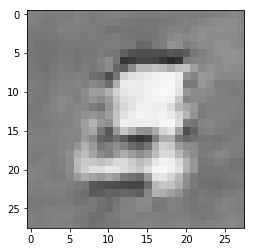

In [30]:
plt.imshow(img)
plt.show()